In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
cd/Users/choejuhui/Desktop/Datasets(Right)

/Users/choejuhui/Desktop/Datasets(Right)


In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_name, transform=None,  target_transform=None):
        df = np.load(file_name)
        self.x_data = df[:,:,:-1]
        self.y_data = df[:,:,-1]
        #self.transform = transform
        #self.target_transform = target_transform
        

    def __getitem__(self, idx):
        x_data = torch.FloatTensor([self.x_data[idx]])
        y_data = torch.Tensor(self.y_data[idx])
        
        return x_data, y_data
        
    def __len__(self):
        return len(self.x_data) #데이터셋 크기 리턴
               
        #i번째 샘플을 찾는데 사용됨. 

In [4]:
dataset = CustomDataset('data_URF_DLB.npy')
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

In [5]:
len(train_dataset)

33

In [6]:
len(val_dataset)

4

In [7]:
len(test_dataset)

5

In [8]:
train_dataloader = DataLoader(train_dataset, shuffle=True)
val_dataloader = DataLoader(val_dataset, shuffle = True)
test_dataloader = DataLoader(test_dataset, shuffle = True)

In [9]:
train_x, train_y = next(iter(train_dataloader))
train_x = train_x.squeeze(dim=1)
train_y = train_y[:,-1].unsqueeze(dim=1)
train_x.size(), train_y.size()

/var/folders/s4/7x4zrn_n0klgd6vbnf75pkn80000gn/T/ipykernel_55422/1330978244.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  x_data = torch.FloatTensor([self.x_data[idx]])


(torch.Size([1, 300, 5]), torch.Size([1, 1]))

In [10]:
input_size= 5
hidden_size = 64
num_layers = 2
dropout_rate= 0.5
num_classes = 1

In [11]:
class LSTM_Chicka(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTM_Chicka,self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.dropout_rate = dropout_rate
        self.lstm =  nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout_rate, batch_first = True)
        self.layer_out = nn.Linear(hidden_size, num_classes) 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        out, _status = self.lstm(x)
        out = self.layer_out(out[:, -1]) 
        out = self.sigmoid(out)

        return out

In [32]:
model = LSTM_Chicka(num_classes, input_size, hidden_size, num_layers, dropout_rate)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer= optimizer)

In [25]:
val_x, val_y = next(iter(val_dataloader))
val_x = val_x.squeeze(dim=1)
val_y = val_y[:,-1].unsqueeze(dim=1)
val_x.size(), val_y.size()

(torch.Size([1, 300, 5]), torch.Size([1, 1]))

In [33]:
train_iterations = []
train_losses = []
val_iterations = []
val_losses = []

In [36]:
def train(num_epochs):

    print("Begin training...") 
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        
         # Training Loop 
        for data in train_dataloader: 
        #for data in enumerate(train_loader, 0): 
            inputs, outputs = data  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            inputs = inputs.squeeze(dim=1)
            outputs = outputs[:,-1].unsqueeze(dim=1)
            optimizer.zero_grad()   # zero the parameter gradients          
            predicted_outputs = model(inputs)   # predict output from the model 
            train_loss = criterion(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer.step()        # adjust parameters based on the calculated gradients 
            running_train_loss +=train_loss.item()  # track the loss value 
        
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dataloader)
        train_iterations.append(epoch)
        train_losses.append(train_loss_value)
            
        # Validation Loop 
        with torch.no_grad(): 
            model.eval() 
            for data in val_dataloader: 
                inputs, outputs = data
                inputs = inputs.squeeze(dim=1)
                outputs = outputs[:,-1].unsqueeze(dim=1)
                predicted_outputs = model(inputs) 
                val_loss = criterion(predicted_outputs, outputs) 
             
               # The label with the highest value will be our prediction 
                _, predicted = torch.max(predicted_outputs, 1) 
                running_vall_loss += val_loss.item()  
                total += outputs.size(0) 
                running_accuracy += (predicted == outputs).sum().item() 
        
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(val_dataloader) 
        val_iterations.append(epoch)
        val_losses.append(val_loss_value)        
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        #if accuracy > best_accuracy:
        #    best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))

In [ ]:
train(100)

Begin training...
Completed training batch 1 Training Loss is: 0.6925 Validation Loss is: 0.7131 Accuracy is 75 %
Completed training batch 2 Training Loss is: 0.6926 Validation Loss is: 0.6916 Accuracy is 75 %
Completed training batch 3 Training Loss is: 0.6857 Validation Loss is: 0.7020 Accuracy is 75 %
Completed training batch 4 Training Loss is: 0.6673 Validation Loss is: 0.6302 Accuracy is 75 %
Completed training batch 5 Training Loss is: 0.6593 Validation Loss is: 0.8286 Accuracy is 75 %
Completed training batch 6 Training Loss is: 0.6431 Validation Loss is: 0.5396 Accuracy is 75 %


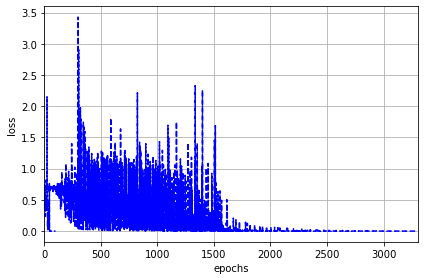

In [21]:
plt.plot(range(1, len(train_iterations)+1), train_losses, 'b--')
plt.plot(range(1, len(val_iterations)+1), val_losses, 'b--')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_iterations)+1) # 일정한 scale
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
train_iterations